# Camera Calibration
> Learn how to calibrate your camera to remove inherent distortions that can affect its perception of the world

**80% of the challenge of building a self-driving car is perception**

--- 

为什么要使用摄像头来感知环境?

Sensors | Spatial-Resolution | 3D | Cost
:-:|:-:|:-:|:-:
Radar or Lidar | Low | Yes | High
Camera | High | No | Low

## Overview

写出一个更好的车道线定位算法，使得它可以处理弯曲的车道线，适应阴影和路面颜色的变化，你需要测量车道线的弯曲程度。以及车辆与道路中心的相对位置。

## Getting Started

## Distortion Correction

Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect.

图片失真发生于摄像头把真实世界的3D物体转换成2D图片时，这个转换并不是完美的

### **Why is it important to correct for image distortion?**
- Distortion can change the apparent **size** of an object in an image.
- Distortion can change the apparent **shape** of an obejct in an image.
- Distortion can cause an object's appearance to change depending on where it is in the field of view.
- Distortion can make objects appear **closer** or **farther away** than they actually are.



## Pinhole Camera Model

### 失真是如何发生的？

针孔摄像头的简单模型：
- 当摄像头生成图像时，是通过聚焦物体所反射的光进行成像的。
- 实际上，生成的图像是翻转倒置的，因为从物体顶部反射的光线，通过针孔后，会继续沿相同角度进行。最终在所生成图像的底部被捕获。

### Types of Distortion
实际上使用的摄像头并不是针孔，使用的是能一次性聚焦大量光线的镜头，这使得其能迅速生成图像。但是镜头仍会产生失真。光线通常会在摄像机镜头的边缘，出现较大幅度或者较小幅度的弯曲。这种失真被称为 **径向畸变(radial distortion)**，是最常见的失真类型。

另一种类型的失真为  **切向畸变(tangential distortion)**，如果摄像机镜头未能与摄像机胶片或者传感器所在的成像平面平行。会导致某些物体会比其真实情况显得更远或者更近

还有利用镜头刻意扭曲图像的例子，例如鱼眼镜头或者广角镜头
这样做是保留径向畸变的风格效果

**radial distortion**,   Real cameras use curved lenses(曲面透镜) to form an image, and light rays often bend a little too much or too little at the edges of these lenses. This creates an effect that distorts the edges of images, so that lines or objects appear more or less curved than they actually are.

**tangential distortion**. This occurs when a camera’s lens is not aligned perfectly parallel to the imaging plane, where the camera film or sensor is. This   makes an image look tilted so that some objects appear farther away or closer than they actually are.

### Distortion Coefficients and Correction

**畸变系数**

有三个系数是用来校正`径向畸变`: k1, k2, k3


<img src='images/camera_calibration/correct.png'>

失真一般可以通过5个参数进行消除。它们的值反映了图像中的径向畸变和切向畸变。

$Distortion_{coefficients}$ = (k1 k2 p1 p2 k3)

<img src='images/camera_calibration/radia_distortion_correction.png'>

`p1` 和 `p2` 系数用来校正切向畸变。

<img src='images/camera_calibration/tangential_distortion_correction.png'>

## Measuring Distortion

棋盘非常适合校准，创建一个将这些失真点映射到未失真点的变换矩阵。最后，矫正所有图像。

> Map distorted points to undistorted points

## Finding Corners

可以使用下面的函数找出棋盘的 corner, 
`cv2.findChessboardCorners()`

`cv2.drawChessboardCorners()`

下面的图中，nx=8, ny=6
<img src='images/camera_calibration/calibration_test.png' width=300, height=300>

```
ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
img = cv2.drawChessboardCorners(img, (8,6), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
```

In [55]:
test_path = 'images/camera_calibration/calibration_test.png'

In [64]:
image = cv2.imread(test_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)
draw_img = cv2.drawChessboardCorners(image, (8, 6), corners, ret)

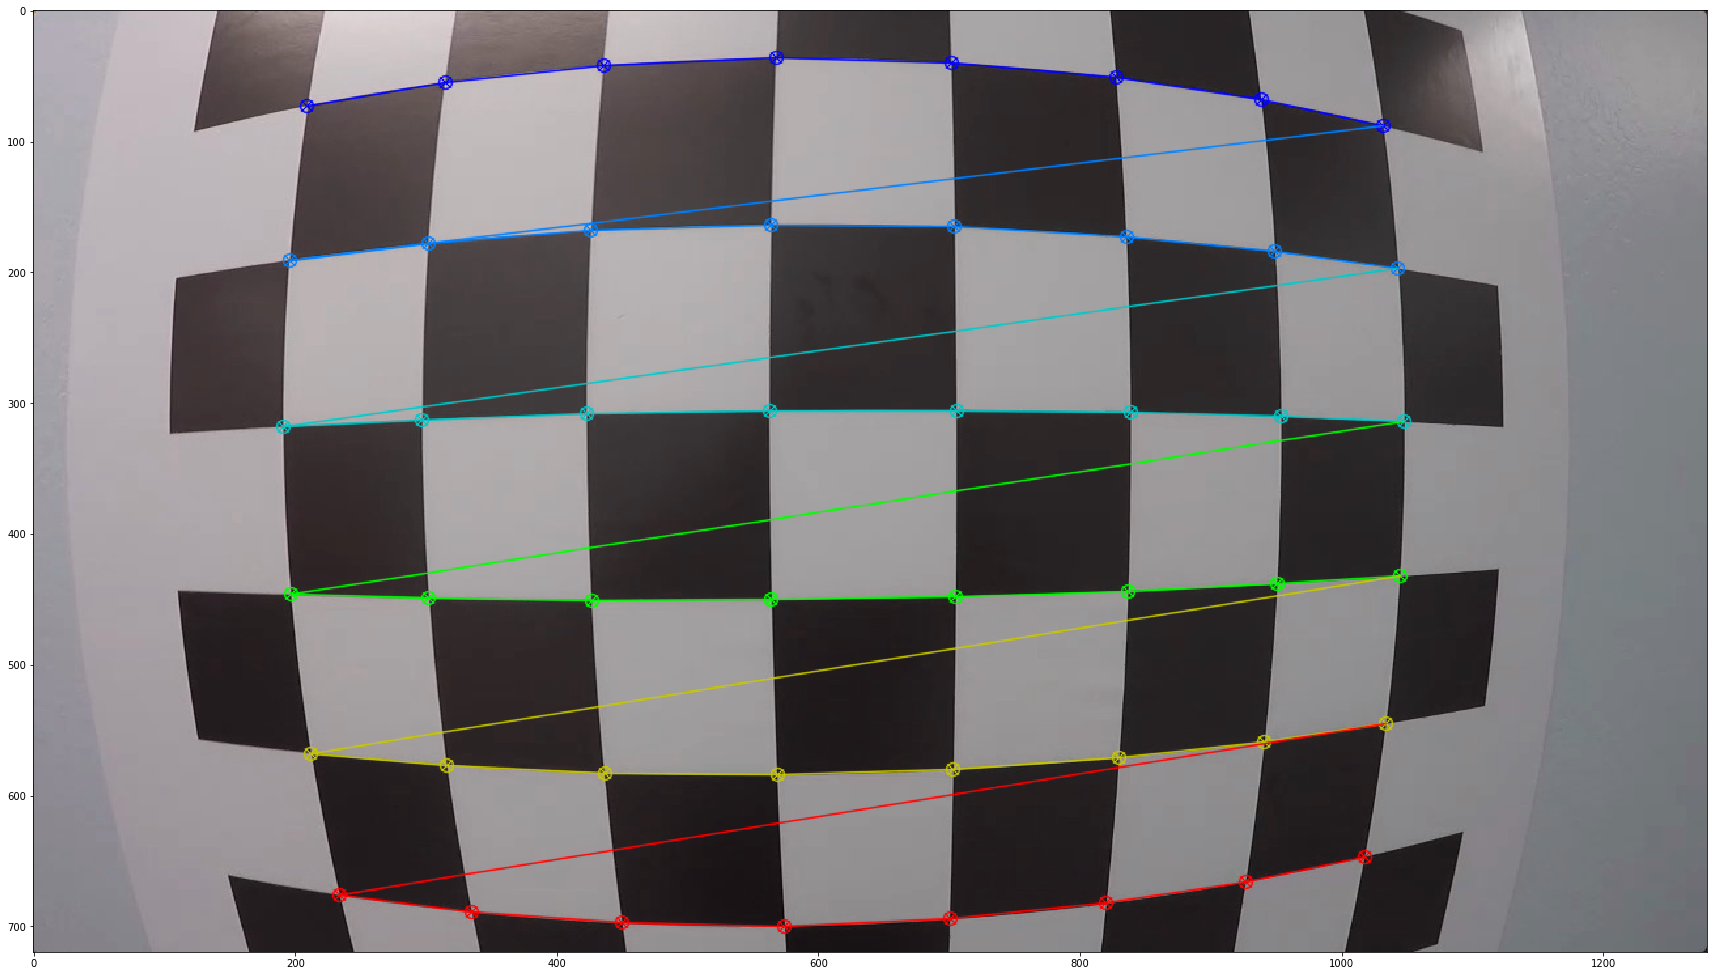

In [66]:
plt.figure(figsize=(30, 24))
plt.imshow(draw_img)

In [67]:
gray.shape

(720, 1280)

In [68]:
gray.shape[::-1]

(1280, 720)

In [71]:
image.shape

(720, 1280, 3)

In [72]:
image.shape[1::-1]

(1280, 720)

## Calibrating Your Camera

In [42]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib qt

In [47]:
DATA_ROOT = 'images/camera_calibration/calibration_wide'

images = glob.glob(DATA_ROOT + '/*.jpg')

In [13]:
plt.imshow(mpimg.imread(images[0]))

In [37]:
# 棋盘上, 水平方向有8个交点, 垂直方向有6个交点
# prepare object points, like(0, 0, 0), (1, 0, 0), (2, 0, 0)
objp = np.zeros((6*8, 3), np.float32)

# np.mgrid[0:8, 0:6]                  => (2, 8, 6)
# np.mgrid[0:8, 0:6].T                => (6, 8, 2)
# np.mgrid[0:8, 0:6].T.reshape(-1, 2) => (48, 2)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image points

# step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)
    
    # If Found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8, 6), corners, ret)
        
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

In [43]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread(os.path.join(DATA_ROOT, 'test_image.jpg'))
img_size = (img.shape[1], img.shape[0]) 

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

cv2.imwrite(os.path.join(DATA_ROOT, 'test_undist.jpg'), dst)

True

Text(0.5, 1.0, 'Undistorted Image')

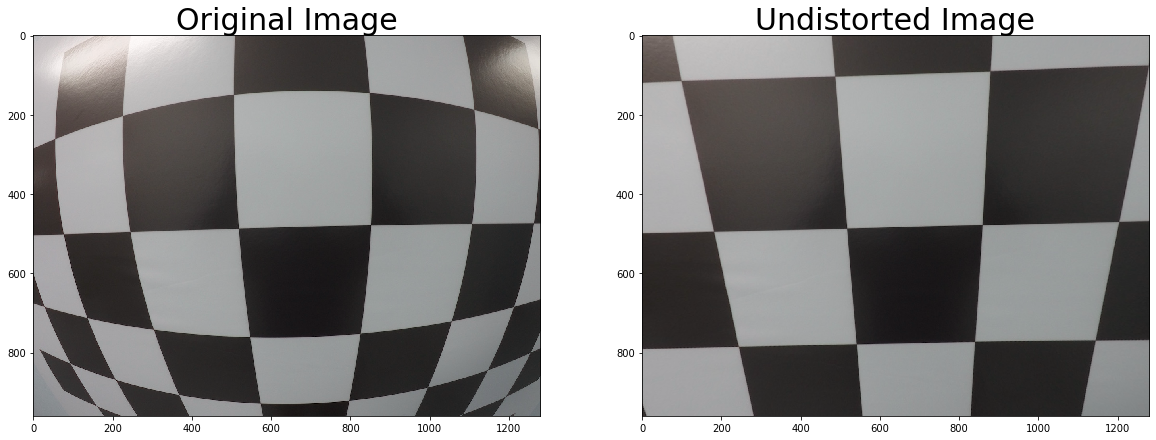

In [45]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open(os.path.join(DATA_ROOT, 'wide_dist_pickle.p'), "wb"))
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Lane Curvature

无人驾驶车需要知道转向角大小，才能左拐或者右拐。
如果我们知道汽车的速度，行驶状态，以及车道的弯曲程度，就可以计算出这个角度车道线的曲率

计算车道线曲率的一种方法是将二次多项式拟合到该线，因为车道线接近于垂直
可以用$f(y) = Ay^{2} + By + C$ 拟合
- `A`: 给出车道线的曲率
- `B`: 给出车道线指向的方向
- `C`: 给出y=0时, 车道线的位置


按以下步骤操作
- 首先，我们采用掩膜和阈值化技术来检测车道线
- 然后进行透视转换(Perspective Transform)， 以获得车道的鸟瞰图。从而使用多项式进行车道线拟合
- 从拟合得到的多项式中获得车道线的曲率


## Perspective Transform

What is perspective?
- 透视是图像中的一种现象，物体距离观察点(如镜头)越远，看起来就越小
- 平行的直线在最远处似乎汇聚到同一个点上


How to?
1. 为进行透视变换，首先需要在原图中选择四个点 `src`，四个点就足以确定从一种视角到另一视角的线性变换。
2. 选择这四个点在变换后出现的位置 `dst`，变换之后的图像称为扭转图像(warped image)
3. `M = cv2.getPerspectiveTransform(src, dst)`
4. `Minv = cv2.getPerspectiveTransform(dst, src)`
5. `warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR`


## Undistort and Transform Perspective

In [76]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load(open(os.path.join(DATA_ROOT, "wide_dist_pickle.p"), "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
test_path = os.path.join(DATA_ROOT, 'test_image2.png')
img = cv2.imread(test_path)
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        
        offset = 100
        
        img_size = (gray.shape[1], gray.shape[0])
        
        src = np.float32([corners[0], 
                          corners[nx-1], 
                          corners[-1], 
                          corners[-nx]])
        
        dst = np.float32([[offset, offset], 
                          [img_size[0] - offset, offset], 
                          [img_size[0] - offset, img_size[1] - offset], 
                          [offset, img_size[1] - offset]])
        
        M = cv2.getPerspectiveTransform(src, dst)
        
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

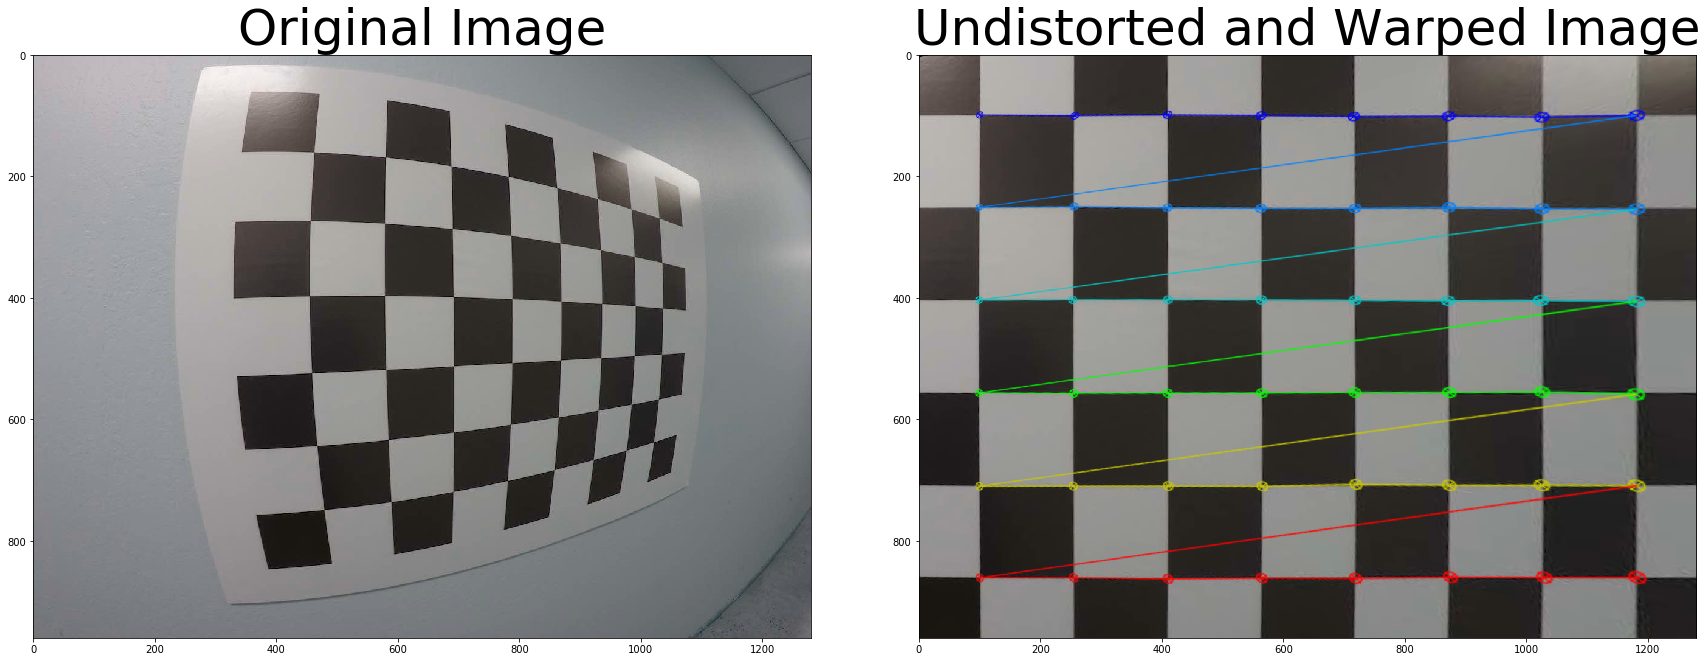

In [77]:
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 总结

PROCESS | PURPOSE
:-|:-
Camera Calibration | To compute the transofrmation between 3D object points in the world and 2D image points
Distortion Correction | To ensure that the geometrical shape of objects is represented consistently, no matter where they appear in an image.
Perspective Transform | To transform an image such that we are effectively viewing objects from a different angle or direction.